# Chapter 3 - Regression Models 
## Segment 3 - Logistic regression

### Objective

We would like to use titanic data, and employ logistic regression to find out how the survival status (a binary variable) is dependent of various continuous or categorical/binary predictors such as age, sex, class, number of siblings/children/parents. 

### Importing required libraries, including the ones for logistic regression


In [230]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

In [231]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [232]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## Logistic regression on the titanic dataset
### Reading the input and preparing the data

In [233]:
address = './titanic-training-data.csv'
titanic_training = pd.read_csv(address)
titanic_training.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
print(titanic_training.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [234]:
print(titanic_training.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


##### VARIABLE DESCRIPTIONS

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

## Verifying that the assumptions of logistic regression is satisfied.
These assumptions are: 
- The predictant variable is binary or ordinal.
- Data is free of missing values.
- All predictors are independent of each other.
- At least, 50 observations per predictor variable exist.

### Checking that your target variable is binary

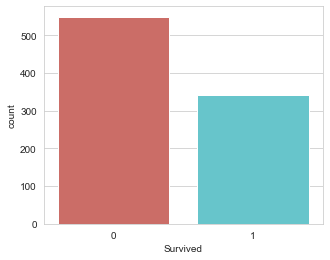

In [235]:
sb.countplot(x='Survived', data=titanic_training, palette='hls')

### Checking for missing values

In [236]:
titanic_training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [237]:
titanic_training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Taking care of missing values
##### Dropping missing values
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
- Survived - This variable is obviously relevant: This is the target variable and should be kept.
- Pclass - Does a passenger's class on the boat affect their survivability? Most likely
- Sex - Could a passenger's gender impact their survival rate? Most likely
- Age - Does a person's age impact their survival rate? Probably
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probably
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probably
- Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
- Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [238]:
titanic_data = titanic_training.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### Imputing missing values
Let's do this based on Parch data. 

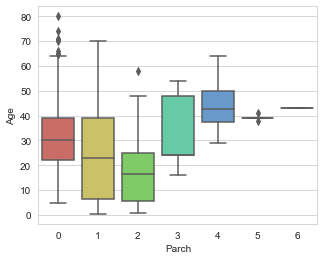

In [239]:
sb.boxplot(x='Parch', y='Age', data=titanic_data, palette='hls')

In [240]:
Parch_groups = titanic_data.groupby(titanic_data['Parch'])
Parch_groups.mean()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,,
0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


Now, we can see the average age in each Parch bin.

So, we write a subroutine that finds a missing value for age and change it to average age of its Parch group.

In [241]:
def age_approx(cols):
    Age = cols[0]
    Parch = cols[1]
    
    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30
        
    else:
        return Age

In [242]:
titanic_data['Age']= titanic_data[['Age', 'Parch']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

The variable Embarked has only 2 missing values, therefore we just drop those data points:

In [243]:
titanic_data.dropna(inplace=True)
titanic_data.reset_index(inplace=True, drop=True)

print(titanic_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.6+ KB
None


### Converting categorical variables to a dummy indicators

For example, we change sex from male/female to 1/0:

In [244]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
gender_cat = titanic_data['Sex']
gender_encoded = label_encoder.fit_transform(gender_cat)
gender_encoded[0:5]

array([1, 0, 0, 0, 1])

In [245]:
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [246]:
# 1 = male / 0 = female
gender_DF = pd.DataFrame(gender_encoded, columns=['male_gender'])
gender_DF.head()

,male_gender
0,1
1,0
2,0
3,0
4,1


Now, we change Embarked from C/Q/S to 2/1/0:

In [247]:
embarked_cat = titanic_data['Embarked']
embarked_encoded = label_encoder.fit_transform(embarked_cat)
embarked_encoded[0:100]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2,
       1, 2, 2, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0,
       1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2])

Change Embarked from category (2/1/0) to binary (1/0):

In [248]:
from sklearn.preprocessing import OneHotEncoder
binary_encoder = OneHotEncoder(categories='auto')
embarked_1hot = binary_encoder.fit_transform(embarked_encoded.reshape(-1,1))
embarked_1hot_mat = embarked_1hot.toarray()
embarked_DF = pd.DataFrame(embarked_1hot_mat, columns = ['C', 'Q', 'S'])
embarked_DF.head()

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [249]:
titanic_data.drop(['Sex', 'Embarked'], axis=1, inplace=True)
titanic_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [250]:
titanic_dmy = pd.concat([titanic_data, gender_DF, embarked_DF], axis=1, verify_integrity=True).astype(float)
titanic_dmy[0:5]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male_gender,C,Q,S
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0


### Checking for independence between features

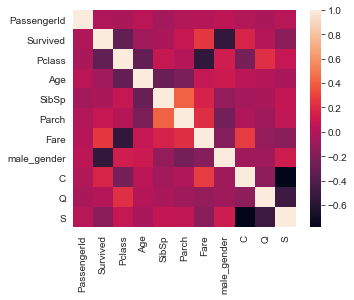

In [251]:
sb.heatmap(titanic_dmy.corr())

There is a strong correlation between Fare and Pclass which is expected: people in high class paid higher fair and vice versa. Since these two variables are dependent, we drop one of them:

In [252]:
titanic_dmy.drop(['Pclass'], axis=1, inplace=True)
titanic_dmy.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,male_gender,C,Q,S
0,1.0,0.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,2.0,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
2,3.0,1.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
3,4.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
4,5.0,0.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0


### Checking that your dataset size is sufficient

In [253]:
titanic_dmy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    float64
 1   Survived     889 non-null    float64
 2   Age          889 non-null    float64
 3   SibSp        889 non-null    float64
 4   Parch        889 non-null    float64
 5   Fare         889 non-null    float64
 6   male_gender  889 non-null    float64
 7   C            889 non-null    float64
 8   Q            889 non-null    float64
 9   S            889 non-null    float64
dtypes: float64(10)
memory usage: 69.6 KB


### Spliting the data into test and train sets

In [254]:
X_train, X_test, y_train, y_test = train_test_split(titanic_dmy.drop('Survived', axis=1),
                                                   titanic_dmy['Survived'], test_size=0.2,
                                                   random_state=200)

In [255]:
print(X_train.shape)
print(y_train.shape)

(711, 9)
(711,)


In [256]:
X_train[0:5]

,PassengerId,Age,SibSp,Parch,Fare,male_gender,C,Q,S
719,721.0,6.0,0.0,1.0,33.0000,0.0,0.0,0.0,1.0
165,167.0,24.0,0.0,1.0,55.0000,0.0,0.0,0.0,1.0
879,882.0,33.0,0.0,0.0,7.8958,1.0,0.0,0.0,1.0
451,453.0,30.0,0.0,0.0,27.7500,1.0,1.0,0.0,0.0
181,183.0,9.0,4.0,2.0,31.3875,1.0,0.0,0.0,1.0


## Deploying the model

In [257]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [258]:
y_pred = LogReg.predict(X_test)

## Model Evaluation
### Classification report without cross-validation

In [259]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86       109
         1.0       0.82      0.67      0.74        69

    accuracy                           0.81       178
   macro avg       0.82      0.79      0.80       178
weighted avg       0.82      0.81      0.81       178



The accuracy of our model is 0.81.

### K-fold cross-validation & confusion matrices

In [260]:
y_train_pred = cross_val_predict(LogReg, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[377,  63],
       [ 90, 181]])

In [261]:
precision_score(y_train, y_train_pred)

0.7418032786885246

### Making a test prediction
Let's select one data point:

In [262]:
titanic_dmy[863:864]

,PassengerId,Survived,Age,SibSp,Parch,Fare,male_gender,C,Q,S
863,866.0,1.0,42.0,0.0,0.0,13.0,0.0,0.0,0.0,1.0


Now, we create a data point similar to the above point, but we only change the age slightly. 

Then, we predict the survival status (using our logistic regression model), and also print the probability of survival:

In [263]:
test_passenger = np.array([866, 42, 0, 0, 13, 0, 0, 0, 1]).reshape(1, -1)

print(LogReg.predict(test_passenger))
print(LogReg.predict_proba(test_passenger))

[1.]
[[0.30155301 0.69844699]]


As you can see, this newly-created test (with only 2-year age difference) has a survival probability of 0.70 or 70%.

### Dependence of survival status to fare

Text(0.5, 1.0, 'Prediction')

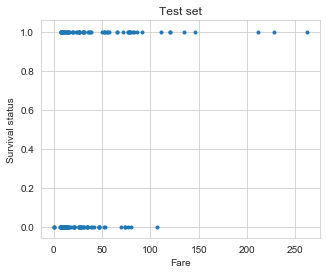

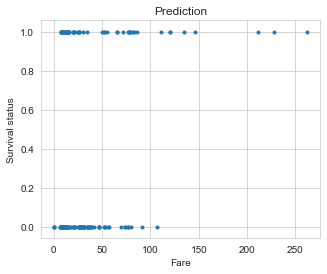

In [264]:
plt.figure()
plt.scatter(X_test['Fare'], y_test, marker = '.')
plt.xlabel('Fare')
plt.ylabel('Survival status')
plt.title('Test set')

plt.figure()
plt.scatter(X_test['Fare'], y_pred, marker = '.')
plt.xlabel('Fare')
plt.ylabel('Survival status')
plt.title('Prediction')

Both test set and prediction show that all passengers with ticket fare higher than $150 survived.


We select two data points of not being survived, and then we only change the fare to $200.

Data point 1:

In [265]:
titanic_dmy[865:866]

,PassengerId,Survived,Age,SibSp,Parch,Fare,male_gender,C,Q,S
865,868.0,0.0,31.0,0.0,0.0,50.4958,1.0,0.0,0.0,1.0


We only change the fare to $200:

In [266]:
test_passenger = np.array([868, 31, 0, 0, 200, 1, 0, 0, 1]).reshape(1, -1)

print(LogReg.predict(test_passenger))
print(LogReg.predict_proba(test_passenger))

[1.]
[[0.27993432 0.72006568]]


Data point 2:

In [267]:
titanic_dmy[866:867]

,PassengerId,Survived,Age,SibSp,Parch,Fare,male_gender,C,Q,S
866,869.0,0.0,32.0,0.0,0.0,9.5,1.0,0.0,0.0,1.0


In [268]:
test_passenger = np.array([869, 32, 0, 0, 200, 1, 0, 0, 1]).reshape(1, -1)

print(LogReg.predict(test_passenger))
print(LogReg.predict_proba(test_passenger))

[1.]
[[0.28321441 0.71678559]]


So, these two passengers would survive with a probability of 72% if they could pay a $200 fare each.

### Dependence of survival status to gender

Again, we select those two data points that did not survive, but now we only change gender:

In [269]:
titanic_dmy[865:866]

,PassengerId,Survived,Age,SibSp,Parch,Fare,male_gender,C,Q,S
865,868.0,0.0,31.0,0.0,0.0,50.4958,1.0,0.0,0.0,1.0


In [270]:
test_passenger = np.array([868, 31, 0, 0, 50.4958, 0, 0, 0, 1]).reshape(1, -1)

print(LogReg.predict(test_passenger))
print(LogReg.predict_proba(test_passenger))

[1.]
[[0.18354763 0.81645237]]


In [271]:
titanic_dmy[866:867]

,PassengerId,Survived,Age,SibSp,Parch,Fare,male_gender,C,Q,S
866,869.0,0.0,32.0,0.0,0.0,9.5,1.0,0.0,0.0,1.0


In [272]:
test_passenger = np.array([869, 32, 0, 0, 9.5, 0, 0, 0, 1]).reshape(1, -1)

print(LogReg.predict(test_passenger))
print(LogReg.predict_proba(test_passenger))

[1.]
[[0.27699162 0.72300838]]


So, these two passengers would survive with a probability of 82% and 72%, respectively, if they had different gender.